## Basic idea
- A lot of (but not all) tasks rely on the concept of 'objectness'.
- **Simple example**: use largest object from input as output / use the uniquely colored object from input as output
- **Intermediate example**: identify all objects from input and change their colors based on some rule that is based on their attributes (e.g. height, size)
- **Advanced examlpe**: identify all objects from input, and glue them together with a common fixation point (e.g. a gray pixel)
- So I thought I'd begin small, just write some funtions that can correctly identify objects and their attributes given an image
- Once we have a list of input-output object pairs, we can then begin to understand the transformation and try to extract the transformation rules
- I believe this is 'hard-coding the prior of objectness'

*This is my first kernel. It is far from complete and I'm sure there are better ways to achieve object identification. If you have any suggestions, please comment below! Many thanks in advance :)*

In [5]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import pdb
import json
from os.path import join as path_join
import cv2
from skimage import measure

In [6]:
# load data
def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)
        with open(task_file, 'r') as f:
            task = json.load(f)
        tasks[file_path[:-5]] = task
    return tasks

# only look as train tasks for now
# train_tasks = load_data('../input/abstraction-and-reasoning-challenge/training/')
train_tasks = load_data('../ARC-master/data/training/')
#evaluation_tasks = load_data('abstraction-and-reasoning-challenge/evaluation/')
#test_tasks = load_data('abstraction-and-reasoning-challenge/test/')

/Users/a18220706/.conda/envs/kaggle-arc/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Define a general class ARC_solver

In [7]:
class ARC_solver:
    def __init__(self, task_num):
        self.task_num = task_num
        # standardize plotting colors
        self.cmap = colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
                                         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        self.norm = colors.Normalize(vmin = 0, vmax = 9)
        # initialize objects-related things
        self.identified_objects = []
        self.io_inx = [] # the original index of the identified objects (io)
        self.io_height = [] # height of io
        self.io_width = [] # width of io
        self.io_pixel_count = [] # count of non-background pixels
        self.io_size = [] # overall grid size
        self.io_unique_colors = [] # number of unique colors
        self.io_main_color = [] # the dominating color
        
    def reset(self):
        self.identified_objects = []
        self.io_inx = [] 
        self.io_height = [] 
        self.io_width = [] 
        self.io_pixel_count = [] 
        self.io_size = [] 
        self.io_unique_colors = [] 
        self.io_main_color = []
    
    def plot_task(self):
        # plot examples of task input-output pairs 
        task = train_tasks[self.task_num]
        cmap = self.cmap
        norm = self.norm
        fig, axs = plt.subplots(1, 5, figsize = (8,2))
        axs[0].text(0.5, 0.5, 'Task', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
        axs[0].get_xaxis().set_visible(False)
        axs[0].get_yaxis().set_visible(False)
        axs[0].axis('off')

        axs[1].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
        axs[1].axis('off')
        axs[1].set_title('Train Input')
        axs[2].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
        axs[2].axis('off')
        axs[2].set_title('Train Output')
        axs[3].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
        axs[3].axis('off')
        axs[3].set_title('Test Input')
        axs[4].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
        axs[4].axis('off')
        axs[4].set_title('Test Output')
        plt.tight_layout()
        plt.show()
    
    def plot_identified_objects(self, identified_objects, title = 'objects'):
        # do not plot anything in the following situations
        if len(identified_objects) == 0:
            print('No objects were identified.')
            return
        if len(identified_objects) > 10:
            print('Way too many objects (>10). Not gonna plot them.')
            return
        
        fig, axs = plt.subplots(1, len(identified_objects) + 1, figsize = (8,2))
        for i in range(len(identified_objects) + 1):
            if i == 0:
                axs[0].text(0.5, 0.5, title, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
                axs[0].get_xaxis().set_visible(False)
                axs[0].get_yaxis().set_visible(False)
                axs[0].axis('off')
            else:
                obj = identified_objects[i-1]
                axs[i].imshow(obj, cmap = self.cmap, norm = self.norm)
                axs[i].axis('off')
                axs[i].set_title('object{}'.format(i))
        plt.tight_layout()
        plt.show()
    
    def get_background(self, image):
        # if image contains 0 
        if 0 in image:
          background = 0
        # else use the most frequent pixel color
        else: 
          unique_colors, counts = np.unique(image, return_counts = True)
          background = unique_colors[np.argmax(counts)]
        return background
    
    def check_pairs(self, inx_pairs, this_pair, return_inx = False):
        # check if this_pair is in inx_pairs
        match = []
        for pair in inx_pairs:
          if pair[0] == this_pair[0] and pair[1] == this_pair[1]:
            match.append(True)
          else:
            match.append(False)
        if return_inx:
          return any(match), np.where(match)
        else:
          return any(match)
    
    def check_neighbors(self, all_pairs, this_pair, objectness, this_object):
        # all_pairs: an array of index pairs for all nonzero/colored pixels
        # this_pair: the index pair whose neighbors will be checked
        # objectness: an array with the shape of original image, storage for how much objectness has been identified
        # this_object: the current object we are looking at
        row_inx = this_pair[0]
        col_inx = this_pair[1]
        objectness[row_inx, col_inx] = this_object
        # find if any neighboring pixels contain color
        if self.check_pairs(all_pairs, [row_inx-1, col_inx-1]): # up-left
          objectness[row_inx-1, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx-1, col_inx]): # up
          objectness[row_inx-1, col_inx] = this_object 
        if self.check_pairs(all_pairs, [row_inx-1, col_inx+1]): # up-right
          objectness[row_inx-1, col_inx+1] = this_object
        if self.check_pairs(all_pairs, [row_inx, col_inx-1]): # left
          objectness[row_inx, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx, col_inx+1]): # right
          objectness[row_inx, col_inx+1] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx-1]): # down-left
          objectness[row_inx+1, col_inx-1] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx]): # down
          objectness[row_inx+1, col_inx] = this_object
        if self.check_pairs(all_pairs, [row_inx+1, col_inx+1]): # down-right
          objectness[row_inx+1, col_inx+1] = this_object
        return objectness
    
    def identify_object_by_color(self, true_image, background = 0):
        # identify obeject by the color only 
        unique_colors = np.unique(true_image)
        for i, color in enumerate(unique_colors):
          image = np.copy(true_image) # make a copy from original first
          if color == background: 
            continue
          image[image != color] = background
          inx = np.where(image == color)
          obj = image[np.min(inx[0]):np.max(inx[0])+1, np.min(inx[1]):np.max(inx[1])+1]
          # append the object attributes
          self.identified_objects.append(obj)
          self.io_inx.append(inx)
          self.io_height.append(obj.shape[0])
          self.io_width.append(obj.shape[1])
          self.io_pixel_count.append(obj[obj != background].shape[0])
          self.io_size.append(obj.size)
          nc, c = np.unique(obj, return_counts = True)
          self.io_unique_colors.append(nc)
          self.io_main_color.append(nc[np.argmax(c)])
    
    def identify_object_by_isolation(self, image, background = 0):
        # identify all objects by physical isolation on the given image
        all_pairs = np.array(np.where(image != background)).T
        objectness = np.zeros(image.shape)
        this_object = 1
        while len(all_pairs) >= 1:
          init_pair = all_pairs[0] # start with the first pair
          objectness = self.check_neighbors(all_pairs, init_pair, objectness, this_object)
          # get a list of index pairs whose neghbors haven't been checked
          unchecked_pairs = np.array(np.where(objectness == this_object)).T
          checked_pairs = np.zeros((0,2)) 
          # check all the index pairs in the expanding unchecked_pairs untill all have been checked
          while len(unchecked_pairs) != 0:
            this_pair = unchecked_pairs[0]
            objectness = self.check_neighbors(all_pairs, this_pair, objectness, this_object)
            # append the checked_pairs
            checked_pairs = np.vstack((checked_pairs, this_pair))
            # get all index pairs for the currently identified object
            current_object_pairs = np.array(np.where(objectness == this_object)).T
            # delete the checked pairs from current object pairs
            checked_inx = []
            for pair in checked_pairs:
              _, inx = self.check_pairs(current_object_pairs, pair, return_inx = True)
              checked_inx.append(inx[0][0])
            unchecked_pairs = np.delete(current_object_pairs, checked_inx, axis = 0)

          # store this object to identified_objects
          current_object_pairs = np.array(np.where(objectness == this_object)).T
          cop = current_object_pairs.T
          obj = image[np.min(cop[0]):np.max(cop[0])+1, np.min(cop[1]):np.max(cop[1])+1]
          # delete the current object pairs from all_pairs 
          cop_inx = []
          for pair in current_object_pairs:
            _, this_cop_inx = self.check_pairs(all_pairs, pair, return_inx = True)
            cop_inx.append(this_cop_inx[0][0])
          all_pairs = np.delete(all_pairs, cop_inx, axis = 0)
          # append the object attributes
          self.identified_objects.append(obj)
          self.io_inx.append(inx)
          self.io_height.append(obj.shape[0])
          self.io_width.append(obj.shape[1])
          self.io_pixel_count.append(obj[obj != background].shape[0])
          self.io_size.append(obj.size)
          nc, c = np.unique(obj, return_counts = True)
          self.io_unique_colors.append(nc)
          self.io_main_color.append(nc[np.argmax(c)])
          # start identifying a new object
          this_object += 1
        return objectness
    
    def identify_object_by_color_isolation(self, true_image, background = 0):
        # identify objects first by color then by physical isolation
        unique_colors = np.unique(true_image)
        for i, color in enumerate(unique_colors):
          image = np.copy(true_image) # make a copy from the original first
          if color == background:
            continue
          # identify objects by isolation in this color only 
          image[image != color] = background
          self.identify_object_by_isolation(image, background = background)
    
    def identify_object(self, image, method):
        # a wrapper of different methods
        # in the future method can be a parameter to be learned
        # 1 = by_color, 2 = by_isolation, 3 = by_color_isolation
        background = self.get_background(image)
        if method == 1:
          self.identify_object_by_color(image, background)
        elif method == 2:
          self.identify_object_by_isolation(image, background)
        elif method == 3:
          self.identify_object_by_color_isolation(image, background)
    
    def extract_object_pairs(self, method):
        # extract all objects from input and output
        num_examples = len(train_tasks[self.task_num]['train'])
        self.input_objects = []
        self.input_objects_inx = []
        self.input_objects_attr = {"height": [],
                                   "width": [],
                                   "pixel_count": [],
                                   "size": [],
                                   "unique_colors": [],
                                   "main_color": []} 
        self.output_objects = []
        self.output_objects_inx = []
        self.output_objects_attr = {"height": [],
                                   "width": [],
                                   "pixel_count": [],
                                   "size": [],
                                   "unique_colors": [],
                                   "main_color": []} 

        # iterate through training examples 
        for i in range(num_examples):
          this_input = np.array(train_tasks[self.task_num]['train'][i]['input'])
          this_output = np.array(train_tasks[self.task_num]['train'][i]['output'])
          # identify all objects in inputs
          arc.reset()
          self.identify_object(this_input, method = method)
          self.input_objects.append(self.identified_objects)
          self.input_objects_inx.append(self.io_inx)
          self.input_objects_attr['height'].append(self.io_height)
          self.input_objects_attr['width'].append(self.io_width)
          self.input_objects_attr['pixel_count'].append(self.io_pixel_count)
          self.input_objects_attr['size'].append(self.io_size)
          self.input_objects_attr['unique_colors'].append(self.io_unique_colors)
          self.input_objects_attr['main_color'].append(self.io_main_color)
          # identify all objects in outputs
          arc.reset()
          self.identify_object(this_output, method = method)
          self.output_objects.append(self.identified_objects)
          self.output_objects_inx.append(self.io_inx)
          self.output_objects_attr['height'].append(self.io_height)
          self.output_objects_attr['width'].append(self.io_width)
          self.output_objects_attr['pixel_count'].append(self.io_pixel_count)
          self.output_objects_attr['size'].append(self.io_size)
          self.output_objects_attr['unique_colors'].append(self.io_unique_colors)
          self.output_objects_attr['main_color'].append(self.io_main_color)

## Let's have a look at the identified objects

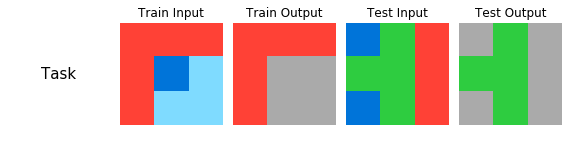

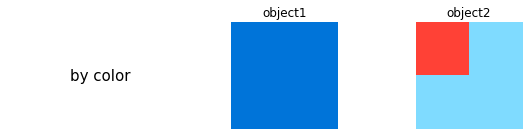

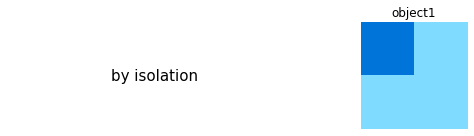

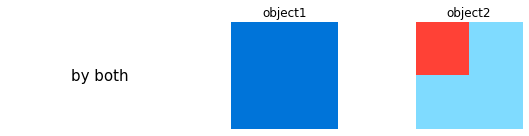

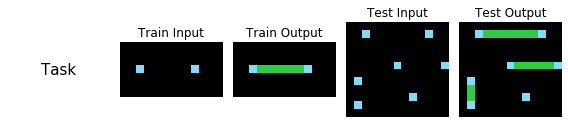

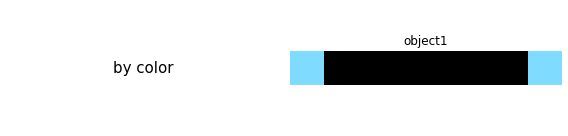

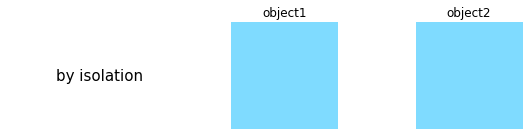

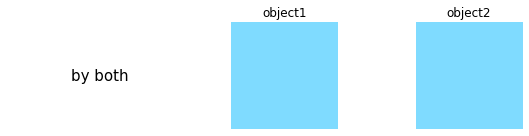

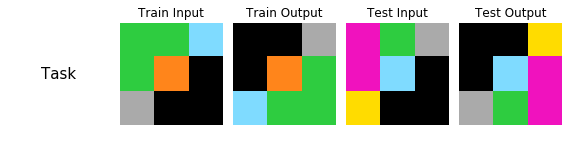

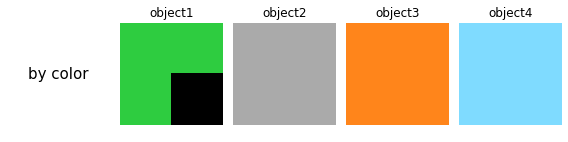

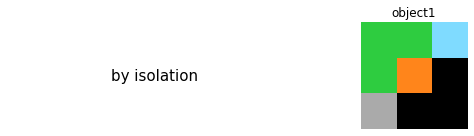

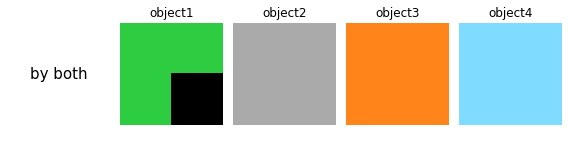

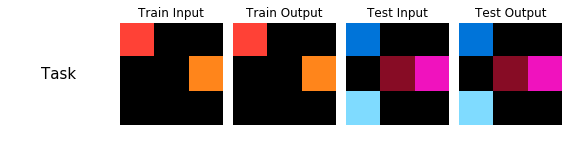

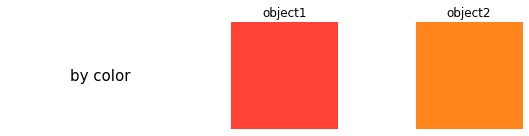

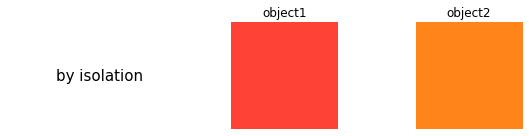

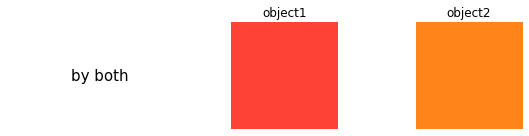

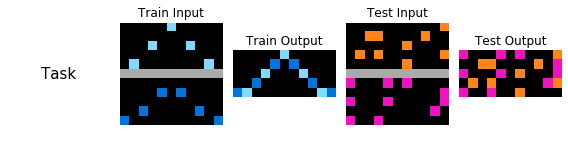

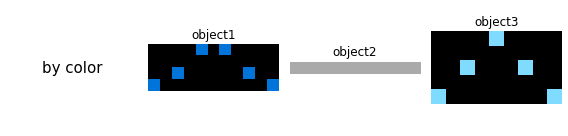

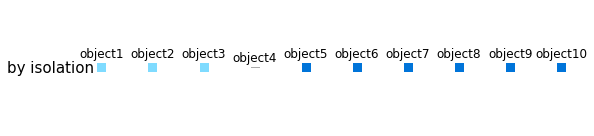

Way too many objects (>10). Not gonna plot them.
Way too many objects (>10). Not gonna plot them.
Way too many objects (>10). Not gonna plot them.


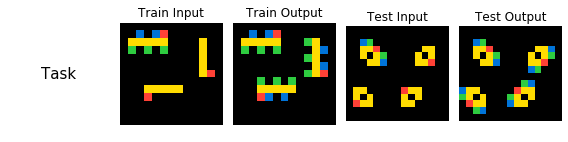

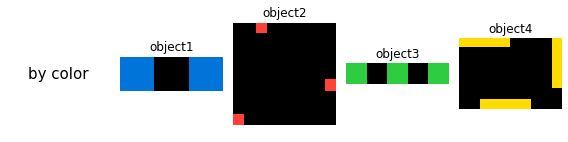

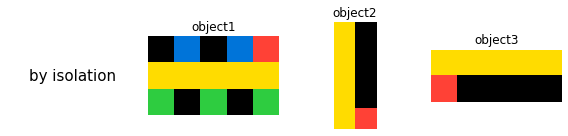

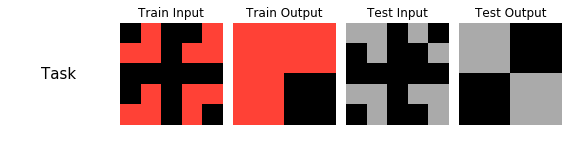

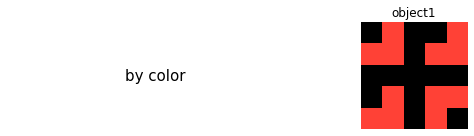

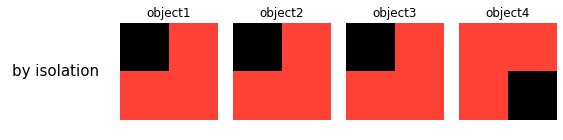

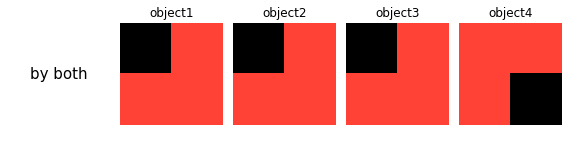

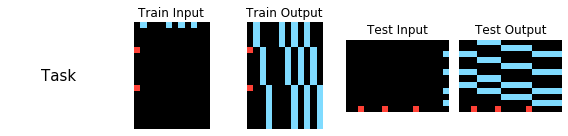

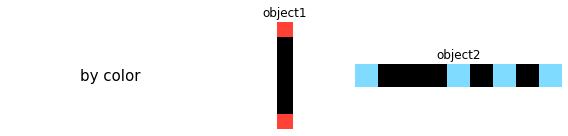

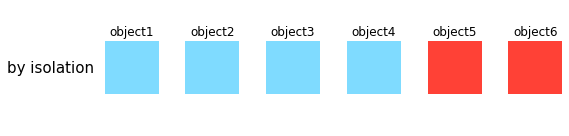

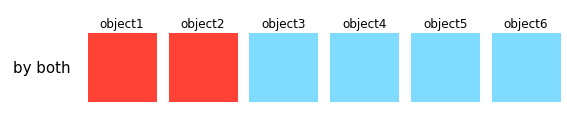

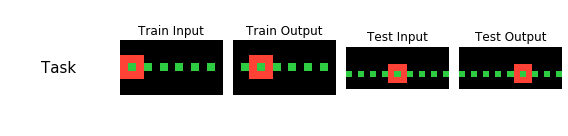

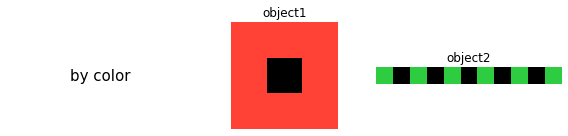

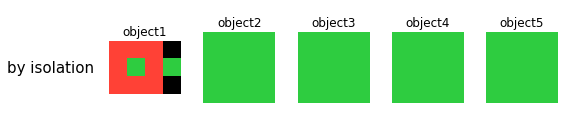

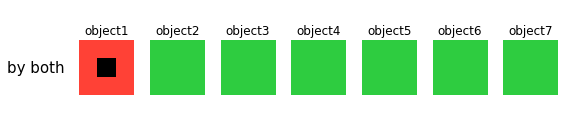

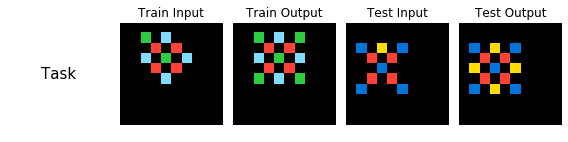

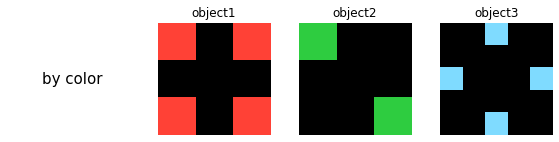

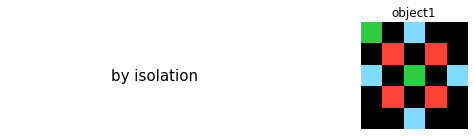

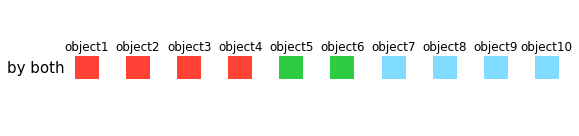

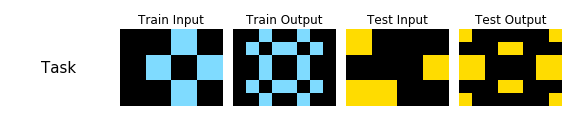

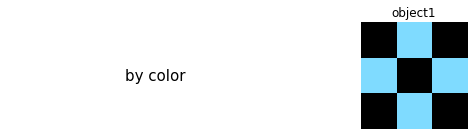

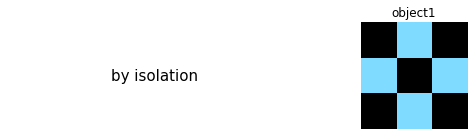

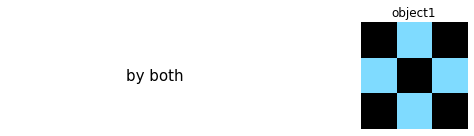

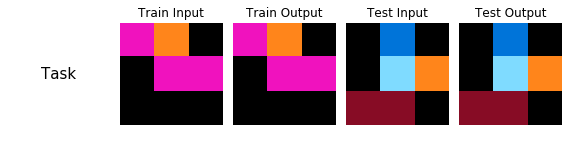

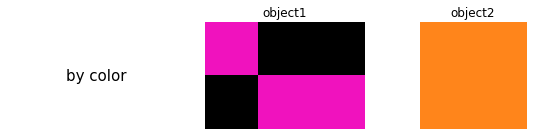

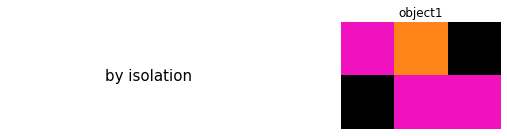

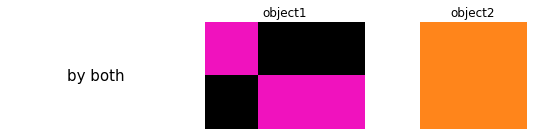

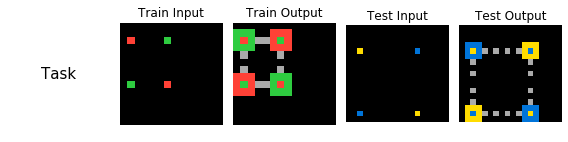

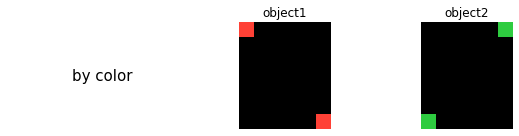

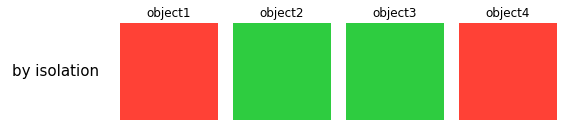

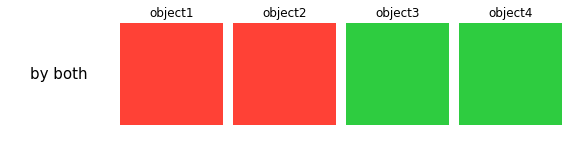

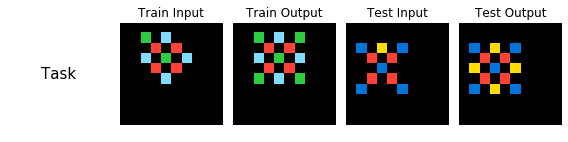

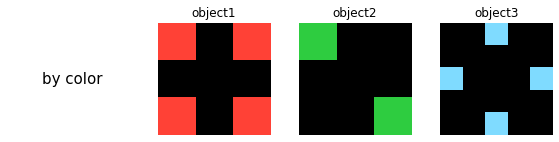

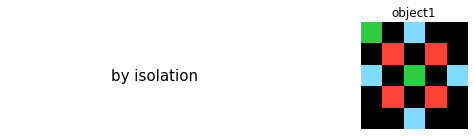

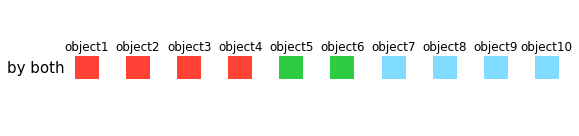

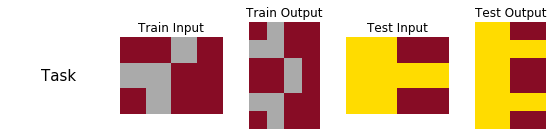

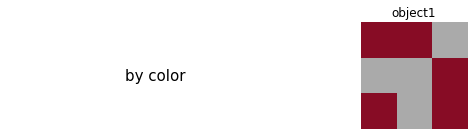

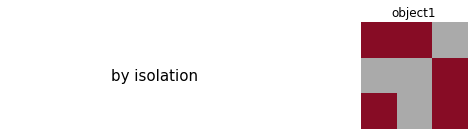

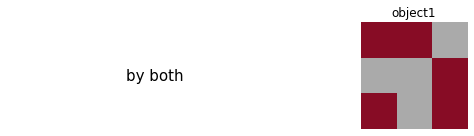

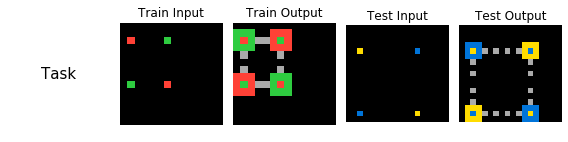

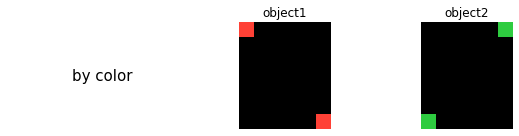

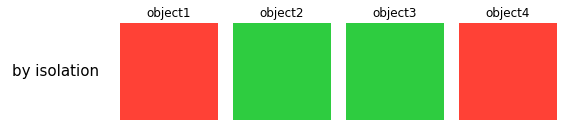

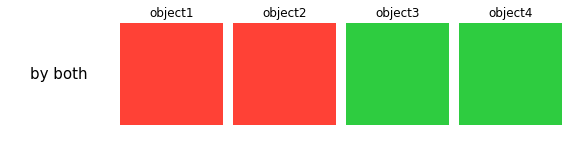

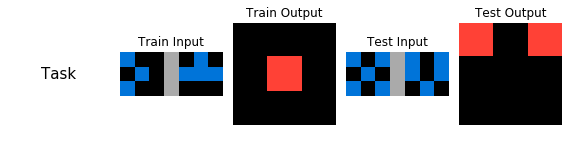

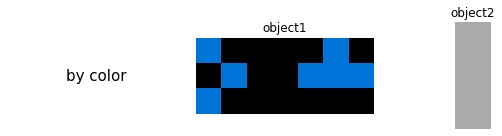

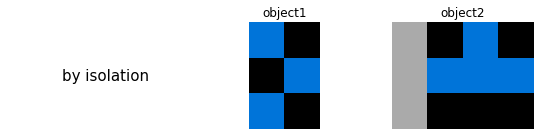

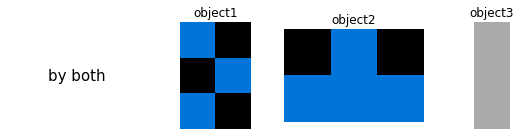

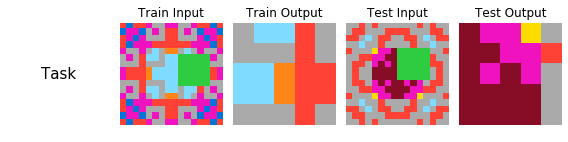

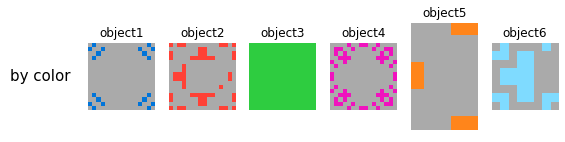

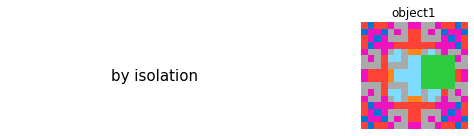

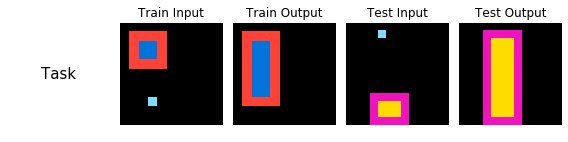

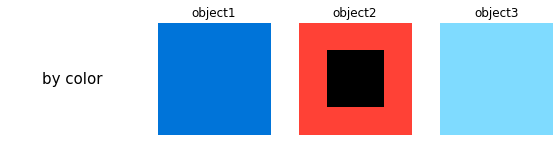

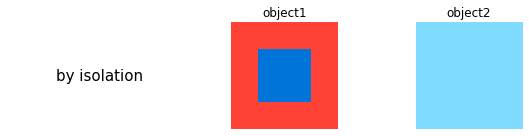

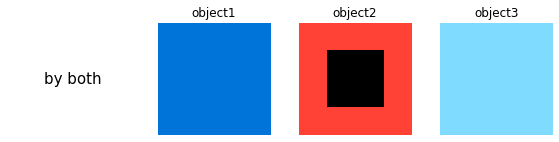

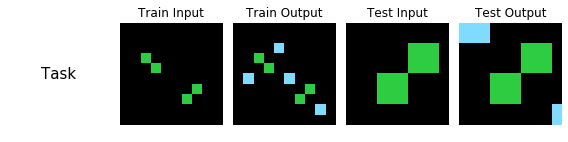

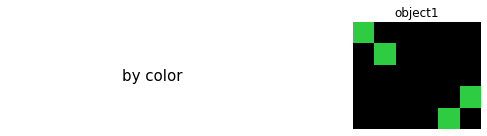

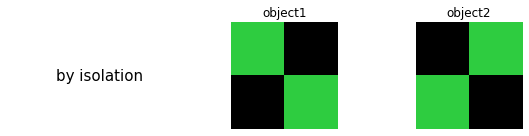

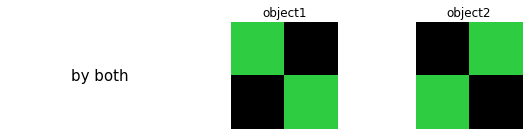

In [8]:
# randomly select 20 task numbers
TASK_NUM = np.random.randint(1,400, size = 20)
for task_num in TASK_NUM:
    arc = ARC_solver(task_num)
    arc.plot_task()
    # select an image for object identification
    # WE USE TRAIN INPUT
    image = np.array(train_tasks[task_num]['train'][0]['input'])

    # identify objects only by color
    arc.reset()
    arc.identify_object(image, method = 1)
    arc.plot_identified_objects(arc.identified_objects, title = 'by color')

    # identify objects only by isolation
    arc.reset()
    arc.identify_object(image, method = 2)
    arc.plot_identified_objects(arc.identified_objects, title = 'by isolation')

    # identify objects by color and isolation
    arc.reset()
    arc.identify_object(image, method = 3)
    arc.plot_identified_objects(arc.identified_objects, title = 'by both')

## Relevant attributes of identified objects are stored

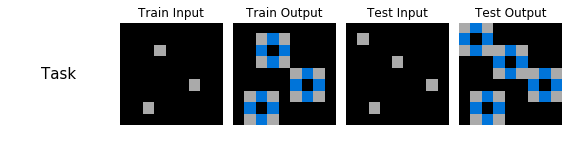

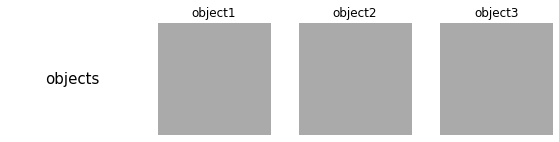

In [9]:
task_num = np.random.randint(1,400)
arc = ARC_solver(task_num)
arc.plot_task()
image = np.array(train_tasks[task_num]['train'][0]['input'])
arc.identify_object(image, method = 2) # by isolation
arc.plot_identified_objects(arc.identified_objects)

In [10]:
print("Identified object 1 has height {}, width {}, pixel count {}.".format(arc.io_height[0], arc.io_width[0], arc.io_pixel_count[0]))
print("It has grid size {}, unique colors of {}, the dominating color is {}.".format(arc.io_size[0], arc.io_unique_colors[0], arc.io_main_color[0]))

Identified object 1 has height 1, width 1, pixel count 1.
It has grid size 1, unique colors of [5], the dominating color is 5.


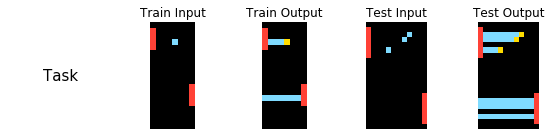

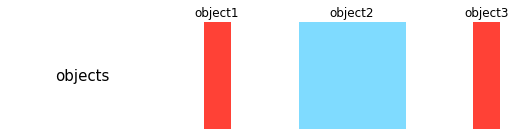

In [11]:
task_num = np.random.randint(1,400)
arc = ARC_solver(task_num)
arc.plot_task()
image = np.array(train_tasks[task_num]['train'][0]['input'])
arc.identify_object(image, method = 2) # by isolation
arc.plot_identified_objects(arc.identified_objects)

In [12]:
print("Identified object 1 has height {}, width {}, pixel count {}.".format(arc.io_height[0], arc.io_width[0], arc.io_pixel_count[0]))
print("It has grid size {}, unique colors of {}, the dominating color is {}.".format(arc.io_size[0], arc.io_unique_colors[0], arc.io_main_color[0]))

Identified object 1 has height 4, width 1, pixel count 4.
It has grid size 4, unique colors of [2], the dominating color is 2.


## Extract input-output pairs if any

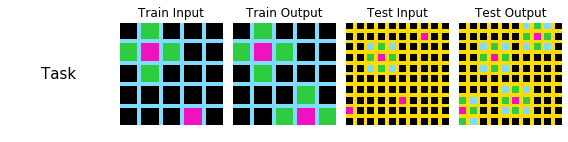

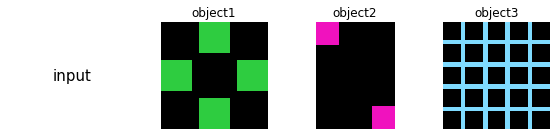

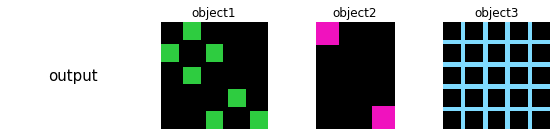

In [13]:
task_num = np.random.randint(1,400)
arc = ARC_solver(task_num)
arc.plot_task()
arc.extract_object_pairs(method = 1) # by color
# plot identified objects from train[0]input
arc.plot_identified_objects(arc.input_objects[0], title = 'input')
# plot identified objects from train[0]output
arc.plot_identified_objects(arc.output_objects[0], title = 'output')

## Input and output objects attributes are stored 


In [14]:
arc.input_objects_attr['pixel_count'][0]

[64, 32, 176]

In [15]:
arc.output_objects_attr['pixel_count'][0]

[112, 32, 176]

In [16]:
arc.input_objects_attr['main_color'][0]

[0, 0, 0]

In [17]:
arc.output_objects_attr['main_color'][0]

[0, 0, 0]

## Limitations
 1. The current three methods: `by_color`, `by_isolation` and `by_color_isolation` works ok with most tasks that require some sort of object identification. But it DOES NOT work when, say, two rectangles with same color are adjacent to each other. The `check_neighbors` function will consider these two a part of the same object. This needs further work.
 2. Initially I want to write a `identify_objects` function that can in one-shot correctly identify the objects as a human would. Later I realized this is quite difficult, as different tasks require different grouping principles. It needs to be learned (trial-and-error, or something else)
 3. `get_background` assumes the background is the most frequent pixel color when it does not contain black. Obviously this logic can be further refined.
 4. All the object identifiers do not understand if an object disappears beyond edge, consequently some remaining part of it are identified as separate objects (if by isolation). Maybe group the identified objects together based on color and/or location (inx)?

## What's next?
1. I think it's easiest to start with tasks that have clear input-output pairs with some simple transformation. 
2. The process goes as following:
   1. Extract all input-output pairs
   2. Pad them to the same size
   3. Push them through a simple CNN
3. The advantage of this method is that now we can increase the data size from #examples to #objects. 
4. If CNN method doesn't work (probably won't), then perhaps we can iterate through all the objects attributes and find the ones that are different (e.g. color, size). And figure out what's the rule (this is the hardest part).